In [1]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import misc

from poppy_roman_cgi_phasec import cgi

from importlib import reload
import copy

wavelength_c = 575e-9*u.m

nlam = 3
bandwidth = 0.1
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
lam_array_broad = np.linspace( minlam, maxlam, nlam )

iwa = 2.8
owa = 9.7

data_dir = Path('/groups/douglase/kians-data-files/poppy-cupy-tests-data')
# misc.save_pickle(data_dir/'hlc_cpu_wfs_mono', wfs)

In [2]:
poppy.conf.use_cupy = True
poppy.conf.use_mkl = True
poppy.conf.use_fftw = True

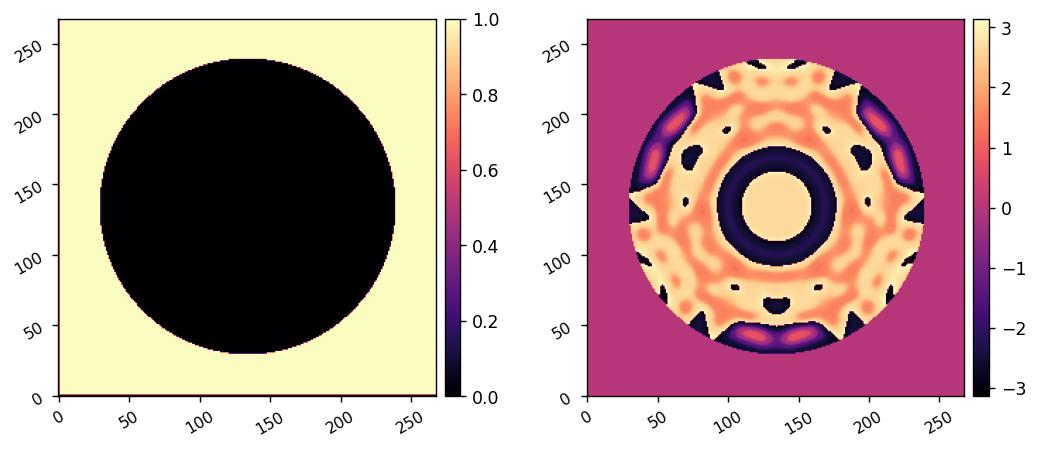

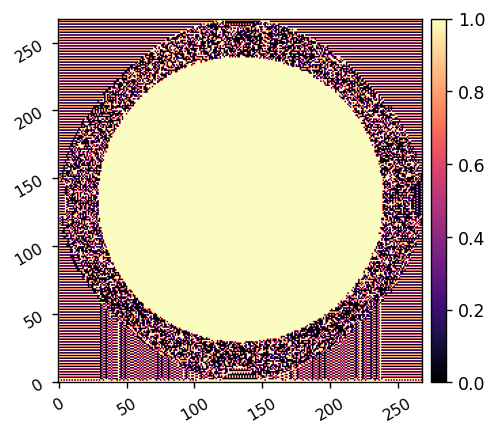

In [5]:
misc.myimshow2(cp.abs(hlc.fpm_phasor)**2, cp.angle(hlc.fpm_phasor))
misc.myimshow(hlc.fpm_mask)

Propagating wavelength 575.000 nm.
PSF calculated in 0.298s


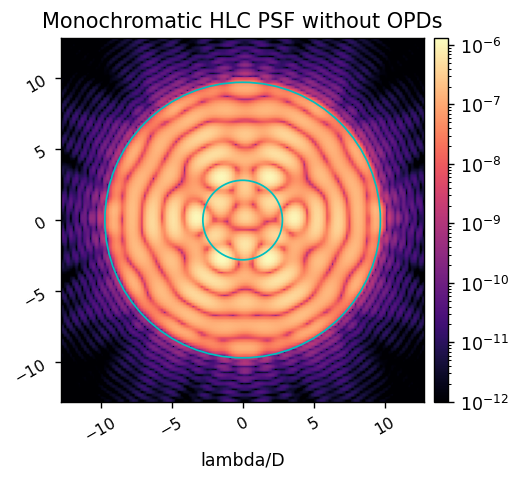

Saved data to:  /groups/douglase/kians-data-files/poppy-cupy-tests-data/hlc_gpu_wfs_mono


In [4]:
reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', npsf=128, psf_pixelscale_lamD=0.2, interp_order=3, use_opds=False)

wfs = hlc.calc_psf()

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, 'Monochromatic HLC PSF without OPDs',
              lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches, vmin=1e-12)

misc.save_pickle(data_dir/'hlc_gpu_wfs_mono', wfs)

In [6]:
!nvidia-smi

Tue Jun  7 12:58:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:25:00.0 Off |                    0 |
| N/A   31C    P0    34W / 250W |  10759MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Test without OPDs implemented

### Monochromatic Test

Propagating wavelength 575.000 nm.
PSF calculated in 0.312s


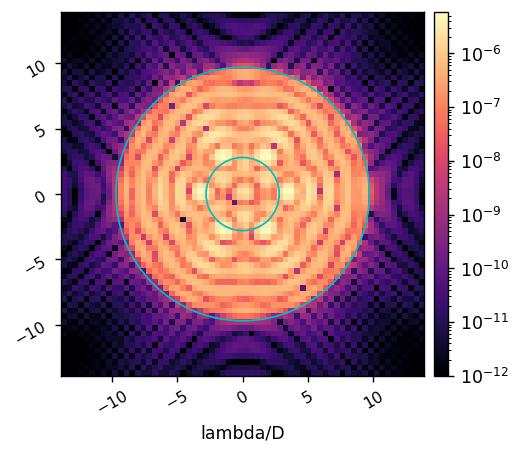

In [6]:
reload(cgi)
hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True)
clear_output()

wfs = hlc.calc_psf(quiet=False)

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches, vmin=1e-12)

### Broadband Test

In [2]:
settings = []
for wavelength in lam_array_broad:
    settings.append({'wavelength':wavelength,
                     'psf_pixelscale_lamD':0.2,
                     'npsf':128})
settings

[{'wavelength': <Quantity 5.4625e-07 m>,
  'psf_pixelscale_lamD': 0.2,
  'npsf': 128},
 {'wavelength': <Quantity 5.75e-07 m>,
  'psf_pixelscale_lamD': 0.2,
  'npsf': 128},
 {'wavelength': <Quantity 6.0375e-07 m>,
  'psf_pixelscale_lamD': 0.2,
  'npsf': 128}]

In [3]:
reload(cgi)
actors = cgi.create_actors(ncpus=10, ngpus=1/3, settings=settings)

actors

[Actor(CGI, 46169fa9ed8e33882310461101000000),
 Actor(CGI, 443d5bf98ac17d903cbfe54501000000),
 Actor(CGI, 9f89374d33228ee9afa6520d01000000)]

In [ ]:
for i in range(len(actors)):
    ray.kill(actors[i])
#     ray.actor.exit_actor()

In [20]:
!nvidia-smi

Tue Jun  7 13:03:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:25:00.0 Off |                    0 |
| N/A   32C    P0    34W / 250W |  13380MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
start = time.time()
pending_wfs = []
for actor in actors:
    future_wfs = actor.calc_psf.remote()
    pending_wfs.append(future_wfs)
wfs = ray.get(pending_wfs)
print('All PSFs calculated in {:.3f}s'.format(time.time()-start))

(CGI pid=62133) Propagating wavelength 546.250 nm.
(CGI pid=62134) Propagating wavelength 575.000 nm.
(CGI pid=62135) Propagating wavelength 603.750 nm.


(CGI pid=62134) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=62134)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=62133) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=62133)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=62135) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=62135)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=62134) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale

All PSFs calculated in 0.540s
(CGI pid=62133) PSF calculated in 0.520s
(CGI pid=62134) PSF calculated in 0.523s
(CGI pid=62135) PSF calculated in 0.522s


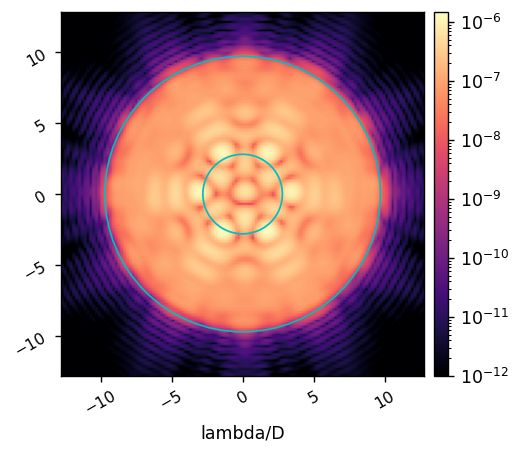

Saved data to:  /groups/douglase/kians-data-files/poppy-cupy-tests-data/hlc_gpu_wfs_broad


In [13]:
psf_broad = 0
for i,wf in enumerate(wfs):
    psf_broad += wf[-1].intensity/nlam
    
patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_broad, lognorm=True, pxscl=settings[0]['psf_pixelscale_lamD'], patches=patches, vmin=1e-12)

misc.save_pickle(data_dir/'hlc_gpu_wfs_broad', wfs)

# Test with OPDs implemented

### Monochromatic Test

Propagating wavelength 575.000 nm.
PSF calculated in 0.479s


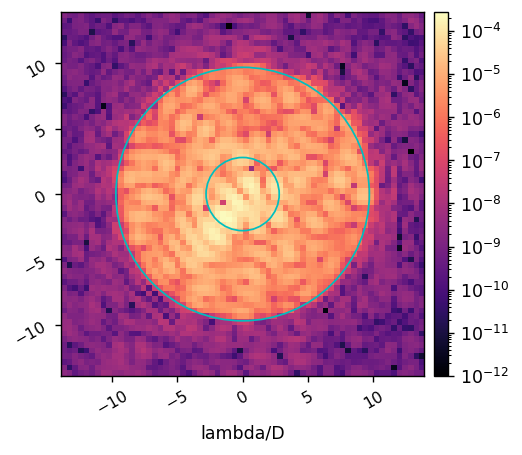

In [9]:
poppy_log.disabled = True

hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=True, polaxis=10)
clear_output()

wfs = hlc.calc_psf(quiet=False)

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches, vmin=1e-12)

### Broadband Test

In [ ]:
hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=True, polaxis=10)

wfs = hlc.calc_psfs(wavelengths=lam_array_broad, ncpus=16, ngpus=1/3, quiet=False)

psf_broad = 0
for i,wf in enumerate(wfs):
    psf_broad += wf[-1].intensity/nlam
    
patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_broad, lognorm=True, pxscl=psf_pixelscale_lamD.value, patches=patches, vmin=1e-12)

# Perform speed tests with different packages.

In [ ]:
n_itr = 1 # number of iterations to calculate a PSF for each case

poppy.conf.use_cupy = False
poppy.conf.use_mkl = False
poppy.conf.use_fftw = False

In [ ]:
times_mono_1 = []
for i in range(n_itr):
    start = time.time()
    hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=False, polaxis=0)
    wfs = hlc.calc_psf(quiet=True)
    times_mono_1.append(time.time()-start)
    print('PSF computed in {:.3f}'.format(times_mono_1[i]))
clear_output(wait=True)
    
times_broad_1 = []
for i in range(n_itr):
    start = time.time()
    hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=False, polaxis=0)
    wfs = hlc.calc_psfs(wavelengths=lam_array_broad, ncpus=22, ngpus=1/2, quiet=True)
    times_broad_1.append(time.time()-start)
    print('PSF computed in {:.3f}'.format(times_mono_1[i]))
clear_output(wait=True)

times_mono_2 = []
for i in range(n_itr):
    start = time.time()
    hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=True, polaxis=10)
    wfs = hlc.calc_psf(quiet=True)
    times_mono_2.append(time.time()-start)
    print('PSF computed in {:.3f}'.format(times_mono_1[i]))
clear_output(wait=True)

times_broad_2 = []
for i in range(n_itr):
    start = time.time()
    hlc = cgi.CGI_POPPY(cgi_mode='hlc', use_fieldstop=True, use_opds=True, polaxis=10)
    wfs = hlc.calc_psfs(wavelengths=lam_array_broad, ncpus=22, ngpus=1/2, quiet=True)
    times_broad_2.append(time.time()-start)
    print('PSF computed in {:.3f}'.format(times_mono_1[i]))
clear_output(wait=True)
